In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask

from osgeo import gdal, osr, ogr
from tqdm import tqdm

In [2]:
def write_raster(array,gdf,outfn):
	'''
	converts a numpy array and a geopandas gdf to a geotiff
	Data values are stored in np.array
	spatial coordinates stored in gdf
	outfn - outpath
	'''

	xmin, ymin = gdf.bounds.minx.values[0], gdf.bounds.miny.values[0]
	xmax, ymax = gdf.bounds.maxx.values[0], gdf.bounds.maxy.values[0]
	nrows, ncols = array.shape
	xres = (xmax-xmin)/float(ncols)
	yres = (ymax-ymin)/float(nrows)
	geotransform =(xmin,xres,0,ymax,0, -yres)   

	output_raster = gdal.GetDriverByName('GTiff').Create(outfn,ncols, nrows, 1 , gdal.GDT_Float32)  # Open the file
	output_raster.SetGeoTransform(geotransform)  # Specify coords
	srs = osr.SpatialReference()                 # Establish encoding
	srs.ImportFromEPSG(4326)                     # WGS84 lat long
	output_raster.SetProjection(srs.ExportToWkt() )   # Export coordinate system 
	output_raster.GetRasterBand(1).WriteArray(array)   # Write array to raster

	print("wrote {}".format(outfn))
	return outfn


In [3]:
gdf = gp.read_file("../shape/sierra_catchments.shp")
stids = list(gdf['stid'].values)

# Define outdirs
results_dir = "../results/wshed_means"
outdir = os.path.join(results_dir,"merged")
clipdir = os.path.join(results_dir,"clipped")

if not os.path.exists(results_dir):
    os.mkdir(results_dir)

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
if not os.path.exists(clipdir):
    os.mkdir(clipdir)


In [4]:
for stid in stids:
    smlt_arr = np.load("../data/Watersheds/smlt/{}_smlt.npy".format(stid))
    prcp_arr = np.load("../data/Watersheds/prcp/{}_prcp.npy".format(stid))
    annual_smean = np.nanmean(smlt_arr* 100, axis = 2) * 365.
    annual_pmean = np.nanmean(prcp_arr, axis = 2) * 365.
    
    stn_gdf = gp.read_file("../shape/{}.shp".format(stid))
    
    write_raster(annual_pmean,stn_gdf,os.path.join(results_dir,"{}_prcp.tiff".format(stid)))
    write_raster(annual_smean,stn_gdf,os.path.join(results_dir,"{}_smlt.tiff".format(stid)))


/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_22666/1542526255.py:4: RuntimeWarning: Mean of empty slice
  annual_smean = np.nanmean(smlt_arr* 100, axis = 2) * 365.
/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_22666/1542526255.py:5: RuntimeWarning: Mean of empty slice
  annual_pmean = np.nanmean(prcp_arr, axis = 2) * 365.
/opt/anaconda3/envs/plotting/lib/python3.9/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


wrote ../results/wshed_means/SJF_prcp.tiff
wrote ../results/wshed_means/SJF_smlt.tiff
wrote ../results/wshed_means/TLG_prcp.tiff
wrote ../results/wshed_means/TLG_smlt.tiff
wrote ../results/wshed_means/ISB_prcp.tiff
wrote ../results/wshed_means/ISB_smlt.tiff
wrote ../results/wshed_means/NAT_prcp.tiff
wrote ../results/wshed_means/NAT_smlt.tiff
wrote ../results/wshed_means/MHB_prcp.tiff
wrote ../results/wshed_means/MHB_smlt.tiff
wrote ../results/wshed_means/NML_prcp.tiff
wrote ../results/wshed_means/NML_smlt.tiff
wrote ../results/wshed_means/ORO_prcp.tiff
wrote ../results/wshed_means/ORO_smlt.tiff
wrote ../results/wshed_means/TRM_prcp.tiff
wrote ../results/wshed_means/TRM_smlt.tiff
wrote ../results/wshed_means/MKM_prcp.tiff
wrote ../results/wshed_means/MKM_smlt.tiff
wrote ../results/wshed_means/SCC_prcp.tiff
wrote ../results/wshed_means/SCC_smlt.tiff
wrote ../results/wshed_means/PNF_prcp.tiff
wrote ../results/wshed_means/PNF_smlt.tiff
wrote ../results/wshed_means/EXC_prcp.tiff
wrote ../re

In [5]:
# Clip by watershed into the clipped dir
for stn_id in stids[:]:
    
    print("****" * 15)
    print("PROCESSING : {}".format(stn_id))
    print("****" * 15)

    # get shapefile 
    catch_shp = os.path.abspath("../shape/{}.shp".format(stn_id))
    
    # Get files matching the wshed 
    wshed_files = [os.path.join(results_dir,x) for x in os.listdir(results_dir) if stn_id in x]
    wshed_files = [os.path.abspath(x) for x in wshed_files]
    
    for fn in wshed_files:
        varfn = os.path.split(fn)[1]
        outfn = os.path.join(clipdir,varfn) 
        if not os.path.exists(outfn):
            cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
            os.system(cmd)
    print("DONE ---")



************************************************************
PROCESSING : SJF
************************************************************
DONE ---
************************************************************
PROCESSING : TLG
************************************************************
DONE ---
************************************************************
PROCESSING : ISB
************************************************************
DONE ---
************************************************************
PROCESSING : NAT
************************************************************
DONE ---
************************************************************
PROCESSING : MHB
************************************************************
DONE ---
************************************************************
PROCESSING : NML
************************************************************
DONE ---
************************************************************
PROCESSING : ORO
**********************************

In [6]:
# Merge files 

prcp_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if "prcp" in x]

# merge and write 
prcp_merged_fn = os.path.join(outdir,"prcp.tiff")
if not os.path.exists(prcp_merged_fn):
    g_prcp = gdal.Warp(prcp_merged_fn, prcp_files, format="GTiff")
    g_prcp = None # Close file
    print("WROTE {}".format(prcp_merged_fn))

In [7]:
smlt_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if "smlt" in x]

smlt_merged_fn = os.path.join(outdir,"smlt.tiff")
if not os.path.exists(smlt_merged_fn):
    g_prcp = gdal.Warp(smlt_merged_fn, smlt_files, format="GTiff")
    g_prcp = None # Close file
    print("WROTE {}".format(smlt_merged_fn))


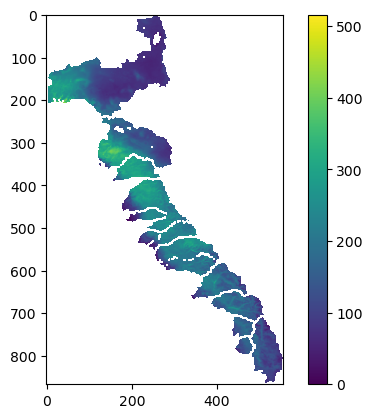

In [8]:
s = rio.open("../results/wshed_means/merged/smlt.tiff")
s2 = s.read(1)
s2[s2 == s.nodata] = np.nan
import matplotlib.pyplot as plt
plt.imshow(s2); plt.colorbar(); plt.show()

<Axes: title={'center': '500m elevation contours '}>

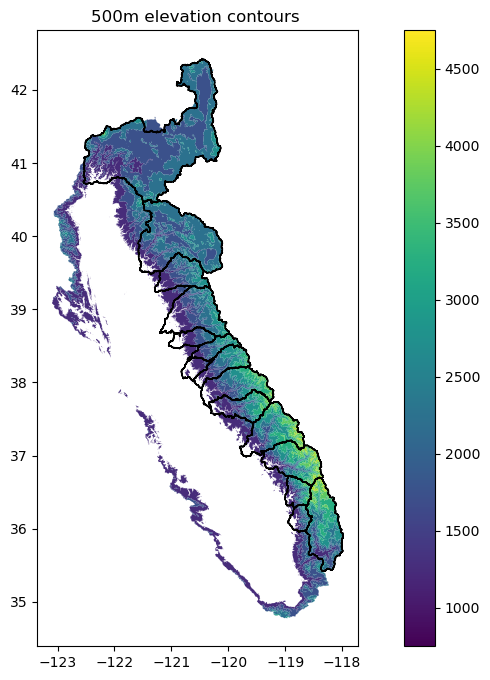

In [9]:
# ELEVATION ANALYSIS 

# Read elevation contours we made 
cont_gdf = gp.read_file("../shape/contours_500m.shp")
cont_gdf['elev'] = np.linspace(250,4750,10) # [int(x) * 500 for x in gdf['ID']] 

# Set alpha val in cmap
cmap = plt.get_cmap('viridis')
cmap.set_under('k', alpha=0)

# plot with watersehds 
ax = cont_gdf.plot(figsize = (12,8), column= 'elev',cmap = cmap, legend = True, vmin = 751)
plt.title('500m elevation contours ')
gp.read_file("../shape/sierra_catchments.shp").plot(ax = ax, facecolor = "none", edgecolor = 'black')

In [10]:
# Define the 500m contour interval 
heights = np.linspace(0,5000,11)
heights = ["{} - {}".format(str(x-500), str(x)) for x in heights]
heights[0] = "<0"

median_hts = np.linspace(250,4750,10)

# Read each contour interval shape
with fiona.open("../shape/contours_500m.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

len(shapes), len(median_hts)


(10, 10)